# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [5]:
N = 10
cls1 = 8
cls2 = 2

node_cls_counts = np.array([cls1, cls2])
probs = node_cls_counts / N
node_entropy = -np.sum(probs * np.log(probs))

print(f'Entropy: {np.round(node_entropy, 2)}')

Entropy: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [6]:
def calc_node_impurity(cls1, cls2, criterion='gini'):
    # Количество представителей классов в узле
    node_cls_counts = np.array([cls1, cls2])
    # Вероятности каждого класса в узле
    probs = node_cls_counts / (cls1 + cls2)
    # Информативность узла (критерий Джини)
    node_impurity = 1 - np.sum(np.square(probs))
    return node_impurity

# Расчёт Impurity Gain
cls1 = 8
cls2 = 2
gain = calc_node_impurity(cls1=cls1, cls2=2) - cls1 / (cls1 + cls2) * calc_node_impurity(cls1=cls1, cls2=0) - cls2 / (cls1 + cls2) * calc_node_impurity(cls1=0, cls2=cls2)
print(f'Impurity Gain: {np.round(gain, 2)}')

Impurity Gain: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [7]:
y = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
y_pred = np.mean(y)
print(np.round(y_pred, 2))

40.6


__Ответ__: для всех 10 объектов, попавших в этот лист регрессионная модель выдаст среднее значение таргетов, попавших в этот лист, т.е. значение 40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [8]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

__Ответ__: обработку категориальных признаков возьмем из конспекта лекции по ссылке в задании. Не будем использовать циклы, векторизуем вычисления благодаря cumsum.

In [9]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    threshold_best = np.inf
    gini_best = -np.inf

    if feature_type == "categorical":
        # Множество значений категориального признака
        uniq_categories = np.unique(feature_vector)
        # Словарь категорий и среднего значения количества объектов этой категории с меткой 1 / среднего ответа объектов этой категории
        category_proportion = {}
        for category in uniq_categories:
            mask = feature_vector == category
            category_proportion[category] = np.mean(target_vector[mask] == 1 if task == "classification" else target_vector[mask])

        # Сортируем категории
        sorted_categories = sorted(category_proportion, key=category_proportion.get)
        # Создаем новый фичи-вектор, где категории меняются на индексы в отсортированном массиве категорий
        feature_vector = np.array([sorted_categories.index(val) for val in feature_vector])

    # Достаём новый порядок объектов по сортировке O(NlogN)
    idx = np.argsort(feature_vector)
    # Сортируем фичу по ее значениям категорий, замененных на индексы / по значениям фичи
    y_sorted, x_sorted = target_vector[idx], feature_vector[idx]

    # Инициализруем трешхолды как средние значения между соседними значениями фичи
    thresholds = 0.5 * (x_sorted[:-1] + x_sorted[1:])
    # Исключаем пороги, где будут пустые разделения и где значения признака повторяются
    valid = x_sorted[:-1] != x_sorted[1:]
    thresholds = thresholds[valid]

    # Обрабатываем константный признак
    if len(np.unique(x_sorted)) <= 1:
        return None, None, threshold_best, gini_best

    if task == "classification":
        # Считаем Джини корневого узла
        _, node_cls_counts = np.unique(y_sorted, return_counts=True)
        node_probs = node_cls_counts / len(y_sorted)
        node_impurity = 1 - np.sum(np.square(node_probs))

        # Инициализируем возможные поклассовые количества объектов при разбиениях (правую и левую часть)
        left_cls_counts = np.array([np.cumsum(y_sorted == cls) for cls in np.unique(y_sorted)])
        left_count = np.arange(1, len(y_sorted) + 1)  # 1, 2, ..., N

        right_cls_counts = left_cls_counts[:, -1].reshape(-1, 1) - left_cls_counts
        right_count = left_count[-1] - left_count[:-1] # N - 1, N - 2, ..., 1

        # Убираем случаи, когда в левой или правой части нет элементов
        left_cls_counts,  right_cls_counts = left_cls_counts[:, :-1], right_cls_counts[:, :-1]
        left_count = left_count[:-1]

        # Расчёт вероятностей в разбиениях
        left_probs = left_cls_counts / left_count
        right_probs = right_cls_counts / right_count

        # Расчёт Джини для разбиений
        left_impurity = 1 - np.sum(np.square(left_probs), axis=0)
        right_impurity = 1 - np.sum(np.square(right_probs), axis=0)

        # Возможные критерии Джини при разбиениях
        ginis = node_impurity - (left_impurity * left_count + right_impurity * right_count) / len(y_sorted)

    elif task == "regression":
        # Считаем дисперсию корневого узла
        node_impurity = np.sum(np.square(np.mean(y_sorted) - y_sorted)) / len(y_sorted)

        # Сумма квадратов таргетов в узле
        y_2 = np.sum(np.square(y_sorted))

        # Инициализируем возможные суммы таргетов при разбиениях (правая и левая часть)
        left_y = np.cumsum(y_sorted) # y1, y1 + y2, ..., y1 + ... + yn
        left_count = np.arange(1, len(y) + 1) # 1, 2, ..., N

        right_y = left_y[-1] - left_y[:-1] # y2 + ... yn, ... , yn
        right_count = left_count[-1] - left_count[:-1] # N - 1, N - 2, ..., 1

        # Убираем случаи, когда в левой или правой части нет элементов
        left_y = left_y[:-1]
        left_count = left_count[:-1]

        # Считаем дисперсии для разбиений через раскрытую и упрощенную формулу дисперсии
        ginis = node_impurity - (y_2 - np.square(left_y) / left_count - np.square(right_y) / right_count) / len(y_sorted)

    # Берем только те Impurity Gains, которые соответствуют правильным thr
    ginis = ginis[valid]
    # Индекс наибольшего гейна, на этом значении надо делать сплит
    gini_best_idx = np.argmax(ginis)
    # Лучший информационный критерий (гейн)
    gini_best = ginis[gini_best_idx]

    if feature_type == "categorical":
        # Создаем множество категорий левого поддерева
        threshold_best = [sorted_categories[i] for i in range(int(thresholds[gini_best_idx] + 0.5))]

    elif feature_type == "real":
        # Лучший thr для данной фичи
        threshold_best = thresholds[gini_best_idx]

    return thresholds, ginis, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [10]:
from sklearn.datasets import fetch_california_housing

In [11]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [12]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [13]:
thresholds, ginis, threshold_best, gini_best = find_best_split(X['MedInc'].values, y, task='regression')

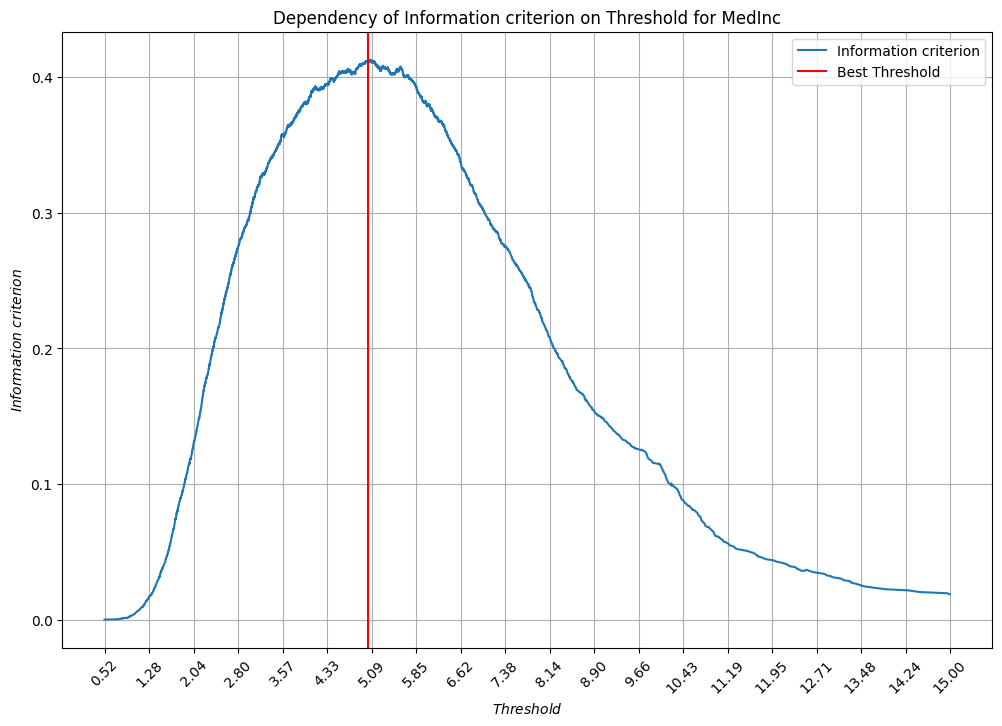

In [14]:
plt.figure(figsize=(12,8))
plt.title('Dependency of Information criterion on Threshold for MedInc')
plt.plot(thresholds, ginis, label='Information criterion')
plt.axvline(x=threshold_best, color='red', label='Best Threshold')
plt.xlabel('$Threshold$')
plt.ylabel('$Information$ $criterion$')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(min(thresholds), max(thresholds), num=20), rotation=45)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [15]:
for feature in X.columns:
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[feature].values, y, task='regression')
    print(f'Feature {feature} threshold_best {threshold_best} gini_best {gini_best}')

Feature MedInc threshold_best 5.03515 gini_best 0.4127513862024045
Feature HouseAge threshold_best 51.5 gini_best 0.0309009405985734
Feature AveRooms threshold_best 6.374305146225346 gini_best 0.1592079525898089
Feature AveBedrms threshold_best 1.1033776245480702 gini_best 0.015253415596107489
Feature Population threshold_best 1160.5 gini_best 0.002830648048046225
Feature AveOccup threshold_best 3.1125433206272035 gini_best 0.0739187057779973
Feature Latitude threshold_best 37.935 gini_best 0.09033408765378681
Feature Longitude threshold_best -121.86500000000001 gini_best 0.05021105203309362


__Ответ__: лучший предикат первой вершины решающего дерева основан на признаке MedInc со значением трешхолда 5.03515, выдающий Impurity Gain 0.41.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [16]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                threshold_best = threshold

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    split = sub_X[:, feature_best] <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации threshold_best - это категории левого поддерева
                    split = np.isin(sub_X[:, feature_best], list(threshold_best))
                else:
                    raise ValueError


        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            # Записываем категории левого поддерева
            node["category_split"] = threshold_best
        else:
            raise ValueError

        # Заполняем словарь Gain'ов для подсчета важности признаков
        impurity_diff = self.impurity_diff(sub_y, sub_y[split], sub_y[np.logical_not(split)])
        if feature_best in self._feature_importances.keys():
            self._feature_importances[feature_best] += impurity_diff
        else:
            self._feature_importances[feature_best] = impurity_diff

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])


    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "nonterminal":
            feature_split = node["feature_split"]

            if self._feature_types[feature_split] == "real":
                if x[feature_split] <= node["threshold"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])

            elif self._feature_types[feature_split] == "categorical":
                if x[feature_split] in node["category_split"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])

        else:
            return node["class"]


    def missing_values(self, X: np.ndarray):
        """
        Обработка пропусков в данных
        """
        for i in range(X.shape[1]):
            if self._feature_types[i] == "real":
                if np.any(np.isnan(X[:, i])):
                    max_val = np.nanmax(X[:, i])
                    X[:, i][np.isnan(X[:, i])] = max_val + 1

            elif self._feature_types[i] == "categorical":
                X[:, i] = np.where(pd.isnull(X[:, i]), "missing", X[:, i])

        return X


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = self.missing_values(X.copy())
        self._fit_node(X, y, self._tree)


    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)


    def impurity_diff(self, y, y_left, y_right):
        """
        Подсчёт gain'ов
        """
        node_impurity = self.node_impurity(y)
        left_impurity = self.node_impurity(y_left)
        right_impurity = self.node_impurity(y_right)

        return node_impurity * len(y) - left_impurity * len(y_left) - right_impurity * len(y_right)


    def node_impurity(self, y):
        """
        Подсчёт impurity для узла при расчете gain'ов
        """
        if self.task == "classification":
            _, node_cls_counts = np.unique(y, return_counts=True)
            probs = node_cls_counts / len(y)
            node_impurity = 1 - np.sum(np.square(probs))

        elif self.task == "regression":
            node_impurity = np.sum(np.square(np.mean(y) - y)) / len(y)

        return node_impurity


    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        total_sum = sum(self._feature_importances.values())
        feature_importances_dict = {key: np.round(value / total_sum, 5) for key, value in self._feature_importances.items()}

        sorted_dict = {key: feature_importances_dict[key] for key in sorted(feature_importances_dict)}
        return sorted_dict

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [18]:
df = pd.read_csv('/content/students.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


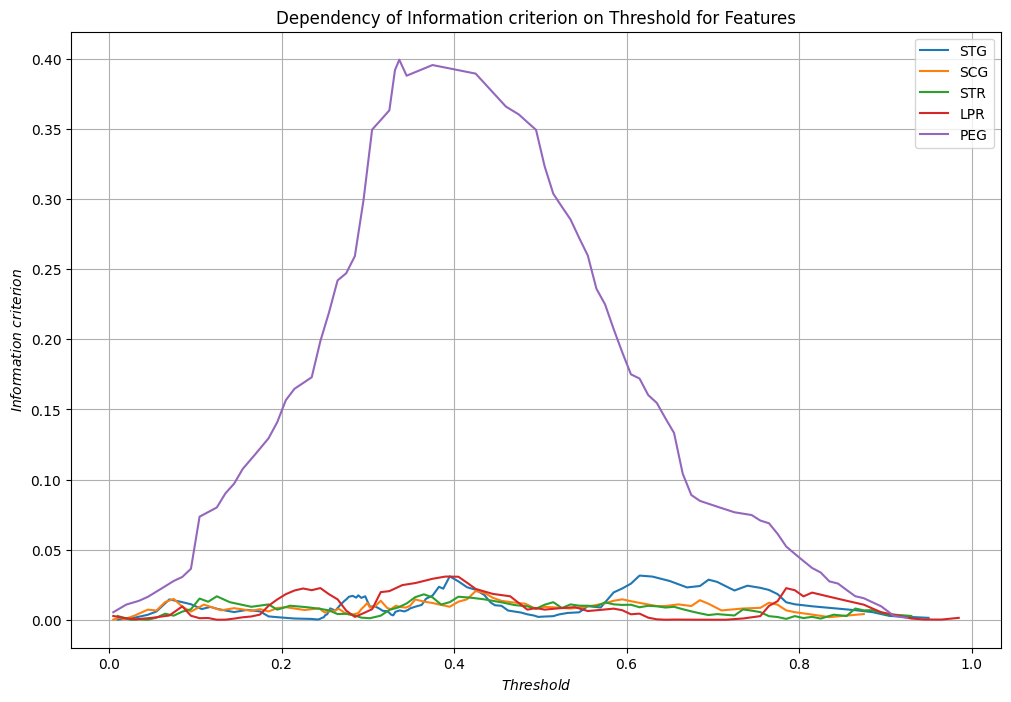

In [19]:
plt.figure(figsize=(12,8))
plt.title('Dependency of Information criterion on Threshold for Features')
for feature in df.columns[:-1]:
    thresholds, ginis, threshold_best, gini_best = find_best_split(df[feature].values, df['UNS'], task='classification')
    plt.plot(thresholds, ginis, label=f'{feature}')

plt.xlabel('$Threshold$')
plt.ylabel('$Information$ $criterion$')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
import seaborn as sns

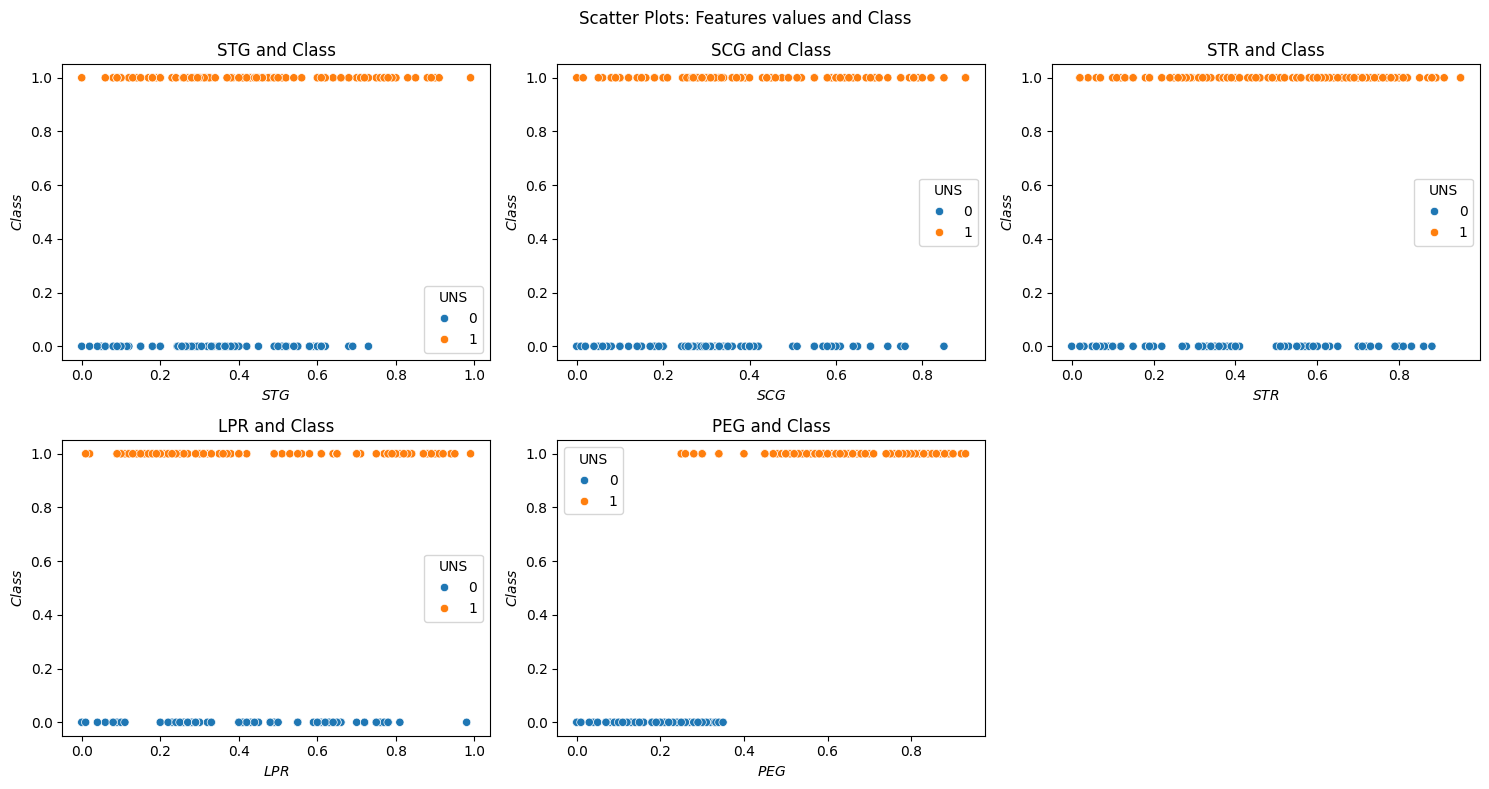

In [21]:
plt.figure(figsize=(15,8))
plt.suptitle('Scatter Plots: Features values and Class')

for i, feature in enumerate(df.columns[:-1], 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df[feature], y=df['UNS'], hue=df['UNS'])
    plt.title(f'{feature} and Class')
    plt.xlabel(f'${feature}$')
    plt.ylabel('$Class$')

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

__Ответ__: Исходя из кривых значений критерия Джини, деление выборки на два поддерева нужно производить по признаку PEG, что согласуется с визуальной оценкой диаграмм рассеяния: на диагрмме PEG vs Class можно заметить разделение выборки по значению около 0.35, которое хорошо разделяет выборку по классам.
Кривые для хороших признаков имеют вид колокола, где достигается ярко выраженный максимум критерия Джини.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [22]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
df = pd.read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

le = LabelEncoder()
df = df.apply(le.fit_transform)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [24]:
X = df.drop(0, axis=1).to_numpy()
y = df[0].to_numpy()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [26]:
feature_types = ['categorical'] * X_train.shape[1]
tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

1.0

Сравним с решающим деревом из Sckearn

In [27]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

1.0

Проверим важность признаков в нашем решающем дереве и дереве из sklearn на датасете, работа с которым будет проводиться в следующем разделе

In [28]:
data = pd.read_csv('diabetes.csv')
X = data.drop('Outcome', axis=1).to_numpy()
y = data['Outcome'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

feature_types = ['real'] * X_train.shape[1]
tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.7142857142857143

In [29]:
pd.DataFrame(
    {"feature": data.drop('Outcome', axis=1).columns, "importance": list(tree.get_feature_importance().values())}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,Glucose,0.37245
1,BMI,0.17267
2,Age,0.11029
3,BloodPressure,0.10167
4,DiabetesPedigreeFunction,0.08042
5,Pregnancies,0.07970
6,SkinThickness,0.06006
7,Insulin,0.02273


In [30]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.7012987012987013

In [31]:
pd.DataFrame(
    {"feature": data.drop('Outcome', axis=1).columns, "importance": tree.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,Glucose,0.334907
1,BMI,0.192618
2,Age,0.139358
3,DiabetesPedigreeFunction,0.089709
4,BloodPressure,0.076993
5,Pregnancies,0.061753
6,Insulin,0.054829
7,SkinThickness,0.049833


__Ответ__: важность признаков в нашем решающем дереве и дереве из Sklearn примерно совпадают.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [32]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [33]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

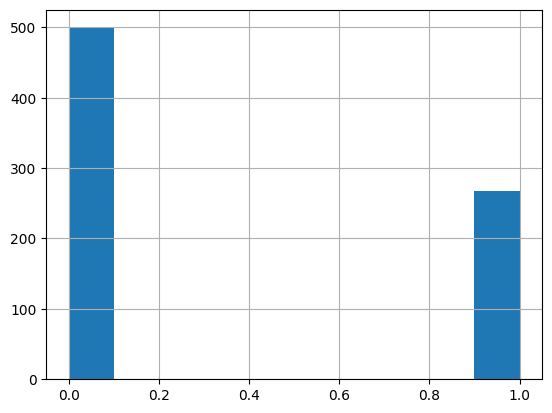

In [34]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [35]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [36]:
from sklearn.metrics import f1_score

In [37]:
dephts_list = range(1, 30)
samples_leaf_list = range(1, 20)
f1_scores = dict()

for depth in dephts_list:
    for samples_leaf in samples_leaf_list:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples_leaf, random_state=42)
        tree.fit(X_train_train, y_train_train)
        y_pred = tree.predict(X_val)
        f1_scores[(depth, samples_leaf)] = f1_score(y_val, y_pred)

best_max_depth, best_min_samples_leaf = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[(best_max_depth, best_min_samples_leaf)]
print(f'Best F1 score: {best_f1_score} \nmax_depth: {best_max_depth} \nmin_samples_leaf: {best_min_samples_leaf}')

Best F1 score: 0.7142857142857143 
max_depth: 7 
min_samples_leaf: 7


In [38]:
best_tree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=7, random_state=42)
best_tree.fit(X_train, y_train)

y_pred = best_tree.predict(X_test)

print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, best_tree.predict_proba(X_test)[:, 1])}')

Accuracy score: 0.696969696969697
Precision score: 0.5555555555555556
Recall score: 0.625
ROC-AUC score: 0.7517384105960265


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [39]:
base_tree = DecisionTreeClassifier(random_state=42)
bag_cls = BaggingClassifier(estimator=base_tree, n_estimators=50, random_state=42)

bag_cls.fit(X_train, y_train)

y_pred = bag_cls.predict(X_test)

print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, bag_cls.predict_proba(X_test)[:, 1])}')

Accuracy score: 0.7489177489177489
Precision score: 0.6309523809523809
Recall score: 0.6625
ROC-AUC score: 0.808319536423841


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [40]:
from sklearn.model_selection import cross_val_score

In [41]:
dephts_list = range(5, 20)
samples_leaf_list = range(1, 20)
f1_scores = dict()

for depth in dephts_list:
    for samples_leaf in samples_leaf_list:
        rf = RandomForestClassifier(n_estimators=50, max_depth=depth, min_samples_leaf=samples_leaf, random_state=42)
        f1_cv_scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='f1')
        f1_scores[(depth, samples_leaf)] = np.mean(f1_cv_scores)

best_max_depth, best_min_samples_leaf = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[(best_max_depth, best_min_samples_leaf)]
print(f'Best F1 score: {best_f1_score} \nmax_depth: {best_max_depth} \nmin_samples_leaf: {best_min_samples_leaf}')

Best F1 score: 0.6749311294765841 
max_depth: 12 
min_samples_leaf: 2


In [42]:
best_rf = RandomForestClassifier(n_estimators=50, max_depth=12, min_samples_leaf=2, random_state=42)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])}')

Accuracy score: 0.7445887445887446
Precision score: 0.6296296296296297
Recall score: 0.6375
ROC-AUC score: 0.8033112582781456


__Ответ__: RandomForest и Bagging показали примерно одинаковые значения метрик качества классификации, но они обе лучше, чем одно решающее дерево DecisionTree

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

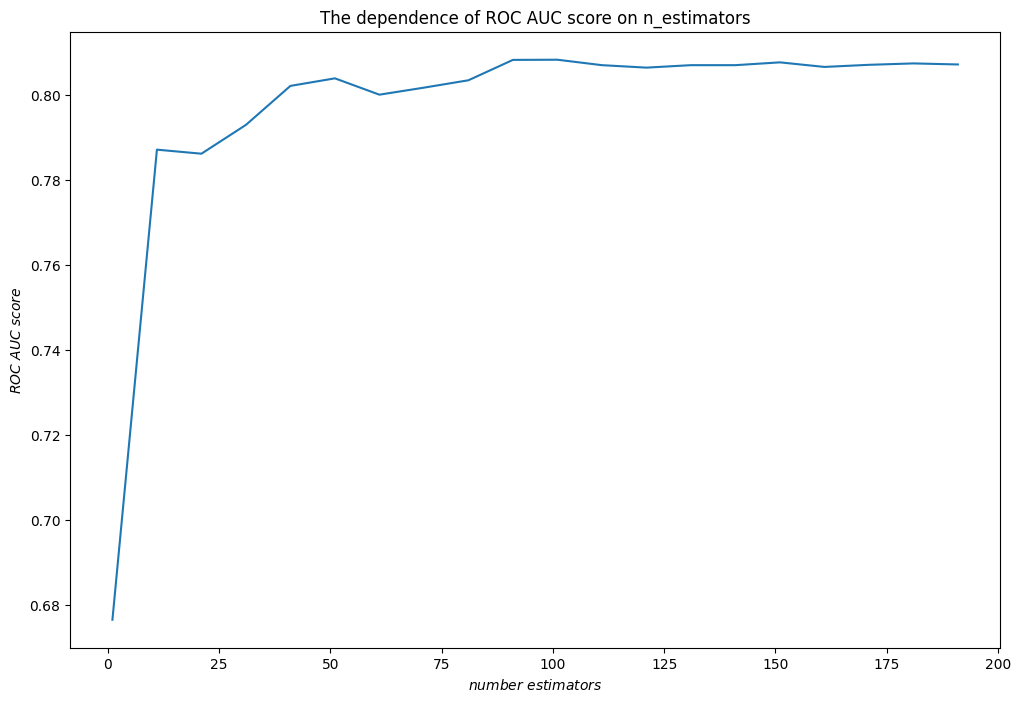

In [43]:
n_estimators_list = range(1, 200, 10)
test_roc_auc = []

for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=12, min_samples_leaf=2, random_state=42)
    rf.fit(X_train, y_train)
    test_roc_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

plt.figure(figsize=(12, 8))
plt.title("The dependence of ROC AUC score on n_estimators")
plt.xlabel("$number$ $estimators$")
plt.ylabel("$ROC$ $AUC$ $score$")
plt.plot(n_estimators_list, test_roc_auc, label='Test')
plt.show()

__Ответ__: из графика можно понять, что RandomForest не переобучается и со значения параметра n_estimators = 90 ROC AUC score выходит на плато.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

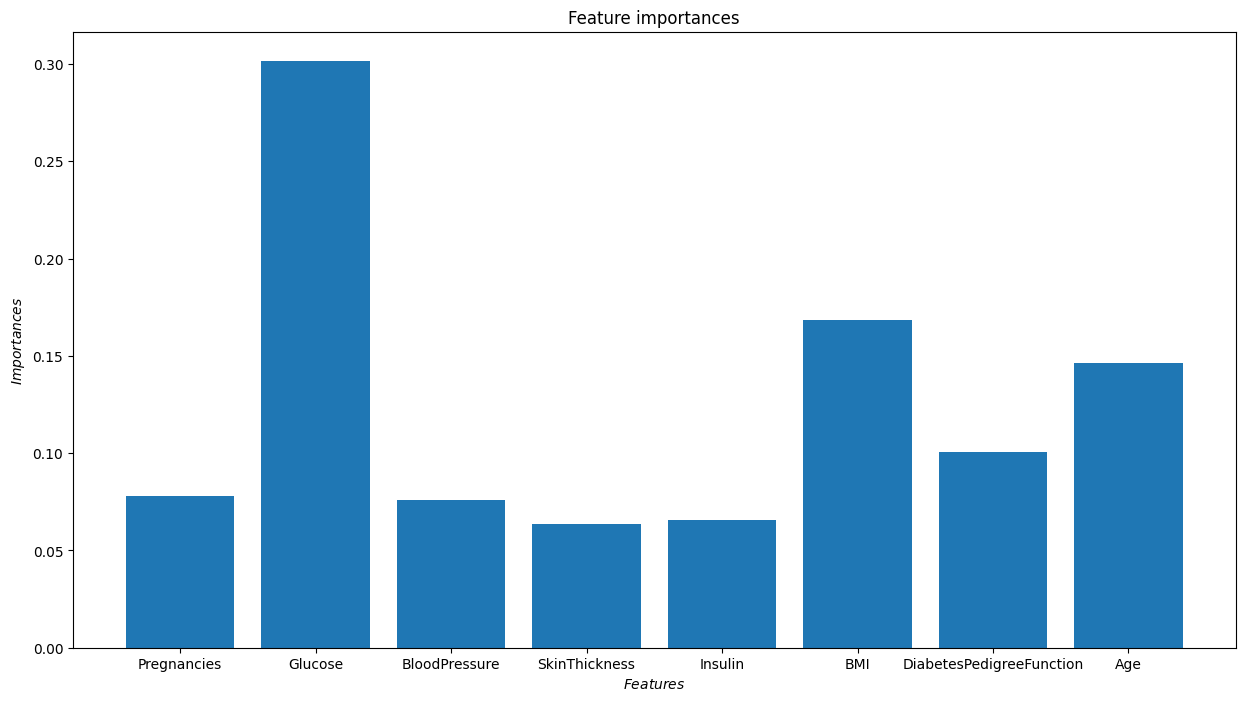

In [44]:
best_rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=2, random_state=42)
best_rf.fit(X_train, y_train)

plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.bar(X.columns, rf.feature_importances_)
plt.xlabel("$Features$")
plt.ylabel("$Importances$")
plt.show()

__Ответ__: Самым важным оказался признак Glucose - концентрация глюкозы в крови.